# Baseball problem: Solution
Copyright © 2020 Oliver Beckstein.

This notebook is based on `12-ODE-applications.ipynb`. The whole problem was live-coded from scratch during class and this notebook is a cleaned-up and commented solution. The lesson showed how
1. to define the physical problem (obtain trajectory of a baseball with spin and air resistance)
2. to derive the underlying equations (Newton's equations of motions and the forces acting on the ball)
3. to adapt an algorithm to solve the equations (use RK4 for integrating the ODEs and express the problem in ODE standard form so that one can use `ode.rk4()`)
4. to visualize and discuss the results (plot trajectories and assess the influence of spin) 

## Packages
We use numpy and our ODE solvers (`ode.py`):

In [1]:
import numpy as np
import ode

For 3D graphs you can use 
```
%matplotlib ipympl
```
but you have to do this as the very first thing (before loading `matplotlib`). You will also have to "close" active figures before you can plot into a new one.

In [2]:
%matplotlib inline
#%matplotlib ipympl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Simple Baseball physics

- quadratic air resistance (with velocity-independent drag coefficient)
- Magnus force due to spin


### Quadratic air resistance
Occurs at high Reynolds numbers, i.e., turbulent flow. Only approximate:

$$
\mathbf{F}_2 = -b_2 v \mathbf{v}
$$

with 
$$
b_2 = \frac{1}{2} C_D \rho A
$$
where $C_D$ is the drag coefficient, $\rho$ the density of air, and $A = r^2 \pi$ the cross sectional area of the baseball.

### Magnus effect 

**Magnus effect**: airflow is changed around a spinning object. The Magnus force is

$$
\mathbf{F}_M = \alpha \boldsymbol{\omega} \times \mathbf{v}
$$

where $\boldsymbol{\omega}$ is the ball's angular velocity in rad/s (e.g., 200/s for a baseball).

For a sphere the proportionality constant $\alpha$ can be written

$$
\mathbf{F}_M = \frac{1}{2} C_L \rho A \frac{v}{\omega} \boldsymbol{\omega} \times \mathbf{v}
$$

where $C_L$ is the lift coefficient, $\rho$ the air density, $A$ the ball's cross section. (Advantage of defining $C_L$ this way: when spin and velocity are perpendicular, the Magnus force is simply $F_M = \frac{1}{2} C_L \rho A v^2$.)

$C_L$ is mainly a function of the *spin parameter*

$$
S = \frac{r\omega}{v}
$$

with the radius $r$ of the ball. In general we write

$$
\mathbf{F}_M = \frac{1}{2} C_L(S)  \frac{\rho A r}{S} \boldsymbol{\omega} \times \mathbf{v}
$$

For a baseball, experimental data show approximately a power law dependence of $C_L$ on $S$

$$
C_L(S) = 0.62 \times S^{0.7}
$$

All together:

\begin{align}
\mathbf{F}_M &= \alpha\ \boldsymbol{\omega} \times \mathbf{v}\\
v &= \sqrt{\mathbf{v}\cdot\mathbf{v}}\\
S &= \frac{r\omega}{v}\\
C_L &= 0.62 \times S^{0.7}\\
\alpha &= \frac{1}{2} C_L  \frac{\rho A r}{S}
\end{align}


### Equations of motion

\begin{align}
\frac{d\mathbf{r}}{dt} &= \mathbf{v}\\
\frac{d\mathbf{v}}{dt} &= -g \hat{\mathbf{e}}_y -\frac{b_2}{m} v \mathbf{v} + \alpha\ \boldsymbol{\omega} \times \mathbf{v}
\end{align}

(quadratic drag $-\frac{b_2}{m} v \mathbf{v}$ included.)


### Baseball simulation 

Implement the full baseball equations of motions:
- gravity $a_\text{gravity}$
- quadratic drag $a_\text{drag}$
- Magnus effect $a_\text{Magnus}$

For the cross product you can look at [numpy.cross()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cross.html).

In [3]:
def C_L(S):
    return 0.62 * S**0.7

def simulate_baseball(v0, omega, r0=None,
                      h=0.01, C_D=0.40, g=9.81, rho=1.225,
                      r=0.07468/2, m=0.14883,
                      R_homeplate=18.4):
    """simulate baseball pitch
    
    Parameters
    ----------
    v0 : array
         initial velocity (vx, vy, vz) in m/s
    omega : array
         angular velocity vector of the ball ("spin"), in rad/s
    r0 : array, optional
         initial position of the ball (in m) when it leaves the pitcher's hand
         as (x, y, z); the default is (0, 2, 0)
    h : float, optional
         integration time step in s, default is 0.01 s
    C_D : float, optional
         drag coefficient, default is 0.40
    g : float, optional
         acceleration due to gravity, default 9.81 kg/(m*s^2)
    rho : float, optional
         density of air, default 1.225 kg/m^3
    r : float, optional
         radius of the baseball
    m : float, optional
         mass of the baseball
    R_homeplate : float, optional
         distance of the catcher from the pitcher
         
    Returns
    -------
    
    positions : array
         The array contains an entry (time, x, y, z) for each time step.
    """
    # all SI units (kg, m)
    if r0 is None:
        r0 = np.array([0, 2, 0])  # pitching at 2m height
    
    omega = np.asarray(omega)
        
    domega = np.linalg.norm(omega)
    A = np.pi*r**2
    rhoArm = rho * A * r / m
    b2 = 0.5 * C_D * rho * A
    
    a_gravity = np.array([0, -g, 0])

    def f(t, y):
        # y = [x, y, z, vx, vy, vz]
        v = y[3:]
        dv = np.linalg.norm(v)
        S = r*domega/dv
        a_magnus = 0.5 * C_L(S) * rhoArm / S * np.cross(omega, v)
        a_drag = -b2/m * dv * v
        a = a_gravity + a_drag + a_magnus
        return np.array([y[3], y[4], y[5],
                         a[0], a[1], a[2]])

    t = 0
    # initialize 3D!
    y = np.array([r0[0], r0[1], r0[2], v0[0], v0[1], v0[2]], dtype=np.float64)
    positions = [[t, y[0], y[1], y[2]]] # record t, x and y, z
    
    while y[0] < R_homeplate and y[1] >= 0.2:
        y[:] = ode.rk4(y, f, t, h)
        positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
        t += h
        
    return np.array(positions)


#### Simulate throws 

Simulate baseball throw for initial velocity $\mathbf{v} = (30\,\text{m/s}, 0)$.

Plot x vs y and x vs z (to see curving).

Try out different spins; a good value is $\boldsymbol{\omega} = 200\,\text{rad/s} \times (0, 1, 1)$.

200 rad/s is 32 revolutions per second or almost 2000 rpm.

In [4]:
print(200/(2*np.pi), "revolutions per second")
print(200/(2*np.pi) * 60, "rpm")

31.830988618379067 revolutions per second
1909.859317102744 rpm


Simulate the baseball throw with
- almost no spin: $\omega = 0.001 \times (0, 0, 1)$  (our code does not handle $\omega = 0$ gracefully...)
- full upward spin: $\omega = 200 \times (0, 0, 1)$
- sideways spin: $\omega = 200 \times (0, 1, 1)$

In [5]:
r = simulate_baseball([30, 0, 0], omega=0.001 * np.array([0,0,1]))
rz = simulate_baseball([30, 0, 0], omega=200. * np.array([0,0,1]))
rzy = simulate_baseball([30, 0, 0], omega=200. * 2**(-0.5) * np.array([0,1,1]))

#### Plotting

Plot the three scenarios in 2D planes: x-y (side view) and x-z (top view).

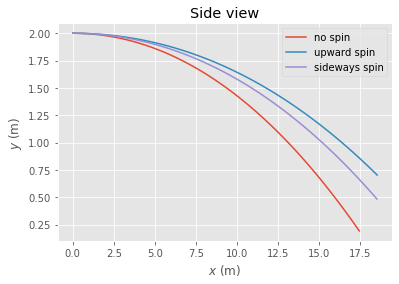

In [6]:
idx = 2  # y
plt.plot(r[:,1], r[:,idx], label="no spin")
plt.plot(rz[:,1], rz[:,idx], label="upward spin")
plt.plot(rzy[:,1], rzy[:,idx], label="sideways spin")
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.legend(loc="best")
plt.title("Side view");

Note how the balls with spin fly higher: the Magnus force lifts them up (due to the component of the spin along $z$).

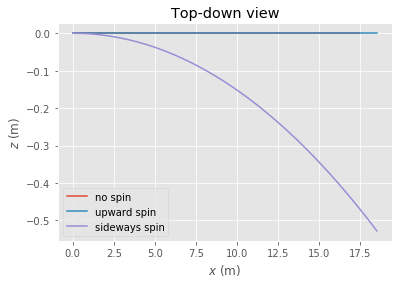

In [7]:
idx = 3  # z
plt.plot(r[:,1], r[:,idx], label="no spin")
plt.plot(rz[:,1], rz[:,idx], label="upward spin")
plt.plot(rzy[:,1], rzy[:,idx], label="sideways spin")
plt.xlabel("$x$ (m)")
plt.ylabel("$z$ (m)")
plt.legend(loc="best")
plt.title("Top-down view");

The ball with a component of the spin along the $y$ direction ($\boldsymbol{\omega} = \omega_0 \, \left(\begin{array}{c} 0\\1\\1\end{array}\right)$) has a 0.6 m deflection in the $-z$ direction.

#### 3D plot
Use simple `matplotlib` 3D plot. (BONUS: Make it work with vpython)

If we use the [`notebook` backend for matplotlib](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) then we will be able to interactively rotate our [matplotlib 3D graphics](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html). (Note: If this does not seem to work, disable adblockers and allow javascript on the page.)

In [32]:
%matplotlib ipympl

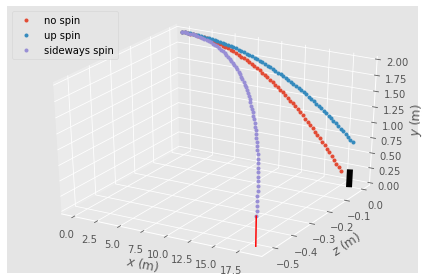

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:,1], r[:,3], r[:,2], '.', label="no spin")
ax.plot(rz[:,1], rz[:,3], rz[:,2], '.', label="up spin")
ax.plot(rzy[:,1], rzy[:,3], rzy[:,2], '.', label="sideways spin")

# hand of the catcher, 0.2m above homeplate
ax.plot([18.4, 18.4], [0, 0], [0, 0.2], color="black", lw=6)

# drop line for last point
x,y,z = rzy[-1, 1:]
ax.plot([x,x], [z,z], [y,0], color="red")

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$z$ (m)")
ax.set_zlabel("$y$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
fig.savefig("baseball.png")

In the plot above we also added the hand of the catcher as a heavy black bar at 0.2 m above the home plate, and a drop-down bar in red to indicate the height of the ball thrown with *sideways spin* to make cleared that it also arrives at almost the same height as the ball with *up spin*.